## Importing all the necassary libraries

In [3]:
import pandas as pd
import numpy as np
import json
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

pd.reset_option('max_colwidth')

nltk.download('words')  
nltk.download('punkt')  

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Sherow\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sherow\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data Analysis and Data Cleaning ##

Loading the Dataset from a CSV File

In [4]:
# Load the dataset from a CSV file into the 'df' DataFrame.
df = pd.read_csv(r'c:\YoutubeProject\US_youtube_trending_data.csv')

Displaying Information About the Dataset

In [5]:
# Use df.info() to display details about the DataFrame, including column names and data types.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229588 entries, 0 to 229587
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   video_id           229588 non-null  object
 1   title              229588 non-null  object
 2   publishedAt        229588 non-null  object
 3   channelId          229588 non-null  object
 4   channelTitle       229588 non-null  object
 5   categoryId         229588 non-null  int64 
 6   trending_date      229588 non-null  object
 7   tags               229588 non-null  object
 8   view_count         229588 non-null  int64 
 9   likes              229588 non-null  int64 
 10  dislikes           229588 non-null  int64 
 11  comment_count      229588 non-null  int64 
 12  thumbnail_link     229588 non-null  object
 13  comments_disabled  229588 non-null  bool  
 14  ratings_disabled   229588 non-null  bool  
 15  description        225188 non-null  object
dtypes: bool(2), int64(5)

Dropping Unnecessary Columns

In [6]:
# Remove the 'thumbnail_link' column
df.drop('thumbnail_link', axis=1, inplace=True)

# Remove the 'video_id' column
df.drop('video_id', axis=1, inplace=True)

# Remove the 'channelId' column
df.drop('channelId', axis=1, inplace=True)

df = df[(df['dislikes'] != 0) | ((df['dislikes'] == 0) & (df['likes'] == 0))]

df = df[(df['view_count'] != 0)]

df= df[df['tags']!= '[none]']

In [7]:
corr=df.corr()
corr

C:\Users\Sherow\AppData\Local\Temp\ipykernel_11676\3182140910.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr=df.corr()


categoryId  view_count     likes  dislikes  comment_count  \
categoryId           1.000000   -0.055030 -0.083263 -0.037977      -0.063501   
view_count          -0.055030    1.000000  0.845533  0.696190       0.531732   
likes               -0.083263    0.845533  1.000000  0.659794       0.709162   
dislikes            -0.037977    0.696190  0.659794  1.000000       0.521833   
comment_count       -0.063501    0.531732  0.709162  0.521833       1.000000   
comments_disabled    0.084442    0.003933 -0.030042  0.008759      -0.019139   
ratings_disabled     0.000329    0.017287 -0.039864 -0.026937      -0.008376   

                   comments_disabled  ratings_disabled  
categoryId                  0.084442          0.000329  
view_count                  0.003933          0.017287  
likes                      -0.030042         -0.039864  
dislikes                    0.008759         -0.026937  
comment_count              -0.019139         -0.008376  
comments_disabled           1.000000          0.229711  
ratings_disabled            0.229711          1.000000

Loading Video Genres from a JSON File

In [8]:
# Open the JSON file containing category information
with open(r'c:\YoutubeProject\US_category_id.json') as f:
    category_dict = json.load(f)  # Store category names and their numerical IDs

# Replace numerical category IDs with their corresponding category names
df['categoryName'] = df['categoryId'].astype(str).replace(category_dict)

# Drop the 'categoryId' column to retain only the category names
df = df.drop('categoryId', axis=1)

df.head(2)

title           publishedAt  \
0                 I ASKED HER TO BE MY GIRLFRIEND...  2020-08-11T19:20:14Z   
1  Apex Legends | Stories from the Outlands ‚Äì ‚ÄúTh...  2020-08-11T17:00:10Z   

   channelTitle         trending_date  \
0      Brawadis  2020-08-12T00:00:00Z   
1  Apex Legends  2020-08-12T00:00:00Z   

                                                tags  view_count   likes  \
0  brawadis|prank|basketball|skits|ghost|funny vi...     1514614  156908   
1  Apex Legends|Apex Legends characters|new Apex ...     2381688  146739   

   dislikes  comment_count  comments_disabled  ratings_disabled  \
0      5855          35313              False             False   
1      2794          16549              False             False   

                                         description    categoryName  
0  SUBSCRIBE to BRAWADIS ‚ñ∂ http://bit.ly/Subscrib...  People & Blogs  
1  While running her own modding shop, Ramya Pare...          Gaming

In [9]:
df = df.drop_duplicates(subset='title')

Turning tags into a list format

In [10]:
# Defining a function for clean text
def clean_tag(tags):
    return [tag.lower().replace('"', '') for tag in tags.split('|')]

# Applying clean textf function for df
df['tags'] = df['tags'].apply(clean_tag)

df = df[df['tags'].apply(lambda x: '[none]' not in x)]

Tokenize title column and removing stop words

In [11]:
# Function to clean and preprocess a title
def clean_title(title):
    # Convert to lowercase
    title = title.lower()
    
    # Remove special characters, numbers, and punctuation
    title = re.sub(r'[^a-zA-Z\s]', '', title)
    
    # Tokenize the title
    tokens = title.split()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Rejoin the cleaned tokens
    cleaned_title = ' '.join(tokens)
    
    return cleaned_title

# Apply the clean_title function to the 'title' column
df['cleaned_title'] = df['title'].apply(clean_title)
df.head(2)

title           publishedAt  \
0                 I ASKED HER TO BE MY GIRLFRIEND...  2020-08-11T19:20:14Z   
1  Apex Legends | Stories from the Outlands ‚Äì ‚ÄúTh...  2020-08-11T17:00:10Z   

   channelTitle         trending_date  \
0      Brawadis  2020-08-12T00:00:00Z   
1  Apex Legends  2020-08-12T00:00:00Z   

                                                tags  view_count   likes  \
0  [brawadis, prank, basketball, skits, ghost, fu...     1514614  156908   
1  [apex legends, apex legends characters, new ap...     2381688  146739   

   dislikes  comment_count  comments_disabled  ratings_disabled  \
0      5855          35313              False             False   
1      2794          16549              False             False   

                                         description    categoryName  \
0  SUBSCRIBE to BRAWADIS ‚ñ∂ http://bit.ly/Subscrib...  People & Blogs   
1  While running her own modding shop, Ramya Pare...          Gaming   

                               cleaned_title  
0                           asked girlfriend  
1  apex legends stories outlands endorsement

Creating a Different Dataset Using Only the **Sports**, **People & Blogs** and **Games** Genre

In [12]:
dfSport = df[df['categoryName'] == 'Sports']
dfPpl=df[df['categoryName'] == 'People & Blogs']
dfGame=df[df['categoryName'] == 'Gaming']

dfSport = dfSport.reset_index(drop=True)
dfSport = dfSport[dfSport['dislikes']!=0]
dfSport.head(2)

title           publishedAt  \
0  Shannon reacts to Kyle Kuzma's game-winning sh...  2020-08-11T16:21:47Z   
1   Giannis Gets Ejected After Headbutting Mo Wagner  2020-08-12T02:30:32Z   

                   channelTitle         trending_date  \
0  Skip and Shannon: UNDISPUTED  2020-08-12T00:00:00Z   
1               Bleacher Report  2020-08-12T00:00:00Z   

                                                tags  view_count  likes  \
0  [fox, fox sports, fs1, fox sports 1, undispute...      540613   7155   
1  [bleacher report, br, nba, giannis, giannis an...      756814   8278   

   dislikes  comment_count  comments_disabled  ratings_disabled  \
0       308           1647              False             False   
1       331           2441              False             False   

                                         description categoryName  \
0  LeBron and the Lakers finally snapped their 3-...       Sports   
1  In a random and wild sequence of events, Giann...       Sports   

                                       cleaned_title  
0  shannon reacts kyle kuzmas gamewinning shot im...  
1         giannis gets ejected headbutting mo wagner

## Exploring the Relationship Between Video Popularity and Tags

**Dropping unecessary columns**

In [13]:
dfSport=dfSport.drop(['comment_count', 'ratings_disabled','description','publishedAt','trending_date','comments_disabled','cleaned_title'], axis=1)

dfPpl=dfPpl.drop(['comment_count', 'ratings_disabled','description','publishedAt','trending_date','comments_disabled','cleaned_title'], axis=1)

dfGame=dfGame.drop(['comment_count', 'ratings_disabled','description','publishedAt','trending_date','comments_disabled','cleaned_title'], axis=1)

dfSport.head(2)

title  \
0  Shannon reacts to Kyle Kuzma's game-winning sh...   
1   Giannis Gets Ejected After Headbutting Mo Wagner   

                   channelTitle  \
0  Skip and Shannon: UNDISPUTED   
1               Bleacher Report   

                                                tags  view_count  likes  \
0  [fox, fox sports, fs1, fox sports 1, undispute...      540613   7155   
1  [bleacher report, br, nba, giannis, giannis an...      756814   8278   

   dislikes categoryName  
0       308       Sports  
1       331       Sports

In [14]:
dfSport['LikesDislikeSum']=dfSport['likes'] + dfSport['dislikes']

dfGame['LikesDislikeSum']=dfGame['likes'] + dfGame['dislikes'] 

dfPpl['LikesDislikeSum']=dfPpl['likes'] + dfPpl['dislikes']

**Extracting tags into a dataframe**

For **dfSports** Dataframe

In [15]:
# Flatten the list of lists in the 'tags' column into a single list of tags
all_tags = [tag for tags in dfSport['tags'] for tag in tags]

# Count the frequency of each tag
tag_frequencies = Counter(all_tags)

# Create a DataFrame to store the tag names and their frequencies
tag_frequencies_df = pd.DataFrame(tag_frequencies.items(), columns=['Tag', 'Frequency'])

# Sort the DataFrame by frequency in descending order
tag_frequencies_df = tag_frequencies_df.sort_values(by='Frequency', ascending=False)

# Reset the index of the DataFrame
tag_frequencies_df = tag_frequencies_df.reset_index(drop=True)
tag_frequencies_df

Tag  Frequency
0                  highlights        455
1                    football        451
2                         nba        400
3                  basketball        295
4                      sports        268
...                       ...        ...
14006  tiger woods responsive          1
14007                us-sport          1
14008          woods accident          1
14009             woods crash          1
14010        greensboro swarm          1

[14011 rows x 2 columns]

For **dfPpl** Dataframe

In [16]:
# Flatten the list of lists in the 'tags' column into a single list of tags
all_tags_P = [tag for tags in dfPpl['tags'] for tag in tags]

# Count the frequency of each tag
tag_frequencies_P = Counter(all_tags_P)

# Create a DataFrame to store the tag names and their frequencies
tag_frequencies_df_P = pd.DataFrame(tag_frequencies_P.items(), columns=['Tag', 'Frequency'])

# Sort the DataFrame by frequency in descending order
tag_frequencies_df_P = tag_frequencies_df_P.sort_values(by='Frequency', ascending=False)

# Reset the index of the DataFrame
tag_frequencies_df_P = tag_frequencies_df_P.reset_index(drop=True)
tag_frequencies_df_P

Tag  Frequency
0                                      funny        178
1                                       vlog        139
2                                     comedy        111
3                                     family         91
4                                     tiktok         87
...                                      ...        ...
9224                   speaking only spanish          1
9225  surprising people with perfect chinese          1
9226   surprising people by speaking chinese          1
9227                               xiaomanyc          1
9228                            morgans barn          1

[9229 rows x 2 columns]

For **dfGame** Dataframe

In [17]:
# Flatten the list of lists in the 'tags' column into a single list of tags
all_tags_G = [tag for tags in dfGame['tags'] for tag in tags]

# Count the frequency of each tag
tag_frequencies_G = Counter(all_tags_G)

# Create a DataFrame to store the tag names and their frequencies
tag_frequencies_df_G = pd.DataFrame(tag_frequencies_G.items(), columns=['Tag', 'Frequency'])

# Sort the DataFrame by frequency in descending order
tag_frequencies_df_G = tag_frequencies_df_G.sort_values(by='Frequency', ascending=False)

# Reset the index of the DataFrame
tag_frequencies_df_G = tag_frequencies_df_G.reset_index(drop=True)
tag_frequencies_df_G

Tag  Frequency
0                           minecraft        713
1                            fortnite        266
2                           challenge        259
3                              gaming        248
4                               funny        235
...                               ...        ...
19196  nintendo switch playing online          1
19197                   online update          1
19198                          breeze          1
19199                 breeze valorant          1
19200                      dokkan now          1

[19201 rows x 2 columns]

**Top 10% Most Used Words with Stop Words Removed and 1 Values Removed**

Sports

In [18]:
# Calculate the total number of unique tags
total_unique_tags = len(tag_frequencies_df)

# Calculate the top 10% threshold
top_10_percent_threshold = int(total_unique_tags * 0.10)

# Filter the tags to get the top 10% most frequent tags
top_10_percent_tags = tag_frequencies_df.head(top_10_percent_threshold)

# Remove tags with a frequency of 1
top_10_percent_tags = top_10_percent_tags[top_10_percent_tags['Frequency'] != 1]

# Reset the index of the DataFrame
top_10_percent_tags = top_10_percent_tags.reset_index(drop=True)
top_10_percent_tags

Tag  Frequency
0            highlights        455
1              football        451
2                   nba        400
3            basketball        295
4                sports        268
...                 ...        ...
1396              media          5
1397  jj redick podcast          5
1398         #badminton          5
1399               #bwf          5
1400          technique          5

[1401 rows x 2 columns]

People & Blogs

In [19]:
# Calculate the total number of unique tags
total_unique_tags_P = len(tag_frequencies_df_P)

# Calculate the top 10% threshold
top_10_percent_threshold_P = int(total_unique_tags_P * 0.10)

# Filter the tags to get the top 10% most frequent tags
top_10_percent_tags_P = tag_frequencies_df_P.head(top_10_percent_threshold_P)

# Remove tags with a frequency of 1
top_10_percent_tags_P = top_10_percent_tags_P[top_10_percent_tags_P['Frequency'] != 1]

# Reset the index of the DataFrame
top_10_percent_tags_P = top_10_percent_tags_P.reset_index(drop=True)
top_10_percent_tags_P

Tag  Frequency
0          funny        178
1           vlog        139
2         comedy        111
3         family         91
4         tiktok         87
..           ...        ...
917       zoella          4
918      i moved          4
919      orlando          4
920  pl-unsolved          4
921      bizarre          4

[922 rows x 2 columns]

Games

In [20]:
# Calculate the total number of unique tags
total_unique_tags_G = len(tag_frequencies_df_G)

# Calculate the top 10% threshold
top_10_percent_threshold_G = int(total_unique_tags_G * 0.10)

# Filter the tags to get the top 10% most frequent tags
top_10_percent_tags_G = tag_frequencies_df_G.head(top_10_percent_threshold_G)

# Remove tags with a frequency of 1
top_10_percent_tags_G = top_10_percent_tags_G[top_10_percent_tags_G['Frequency'] != 1]

# Reset the index of the DataFrame
top_10_percent_tags_G = top_10_percent_tags_G.reset_index(drop=True)
top_10_percent_tags_G

Tag  Frequency
0                            minecraft        713
1                             fortnite        266
2                            challenge        259
3                               gaming        248
4                                funny        235
...                                ...        ...
1915  among us animation mini crewmate          4
1916              apex legends trailer          4
1917               minecraft mega base          4
1918              fortnite funny fails          4
1919                             irish          4

[1920 rows x 2 columns]

**Identifying the Presence of Top 10%**

Sports

In [21]:
# Extract the tags from the 'Tag' column of the top_10_percent_tags DataFrame
top_10_percent_words = top_10_percent_tags['Tag'].tolist()

# Create a set of the top 10% most used words
top_10_percent_words_set = set(top_10_percent_words)

# Function to check if any word from the top 10% is present in the tags list
def contains_top_words(tags):
    for tag in tags:
        if tag in top_10_percent_words_set:
            return 'Used'
    return 'Not Used'

# Apply the function to the 'tags' column of the dfSport DataFrame
dfSport['TagUsage'] = dfSport['tags'].apply(contains_top_words)

People & Blogs

In [22]:
# Extract the tags from the 'Tag' column of the top_10_percent_tags DataFrame
top_10_percent_words_P = top_10_percent_tags_P['Tag'].tolist()

# Create a set of the top 10% most used words
top_10_percent_words_set_P = set(top_10_percent_words_P)

# Function to check if any word from the top 10% is present in the tags list
def contains_top_words(tags):
    for tag in tags:
        if tag in top_10_percent_words_set_P:
            return 'Used'
    return 'Not Used'

# Apply the function to the 'tags' column of the dfSport DataFrame
dfPpl['TagUsage'] = dfPpl['tags'].apply(contains_top_words)

Games

In [23]:
# Extract the tags from the 'Tag' column of the top_10_percent_tags DataFrame
top_10_percent_words_G = top_10_percent_tags_G['Tag'].tolist()

# Create a set of the top 10% most used words
top_10_percent_words_set_G = set(top_10_percent_words_G)

# Function to check if any word from the top 10% is present in the tags list
def contains_top_words(tags):
    for tag in tags:
        if tag in top_10_percent_words_set_G:
            return 'Used'
    return 'Not Used'

# Apply the function to the 'tags' column of the dfSport DataFrame
dfGame['TagUsage'] = dfGame['tags'].apply(contains_top_words)

**Counting the Presence of the top 10% Most Used Tages**

Sports

In [24]:
def count_top_tags(tags):
    count = 0
    for tag in tags:
        if tag in top_10_percent_tags['Tag'].values:
            count += 1
    return count
dfSport['top_10_percent_count'] = dfSport['tags'].apply(count_top_tags)
dfSport.head(2)

title  \
0  Shannon reacts to Kyle Kuzma's game-winning sh...   
1   Giannis Gets Ejected After Headbutting Mo Wagner   

                   channelTitle  \
0  Skip and Shannon: UNDISPUTED   
1               Bleacher Report   

                                                tags  view_count  likes  \
0  [fox, fox sports, fs1, fox sports 1, undispute...      540613   7155   
1  [bleacher report, br, nba, giannis, giannis an...      756814   8278   

   dislikes categoryName  LikesDislikeSum TagUsage  top_10_percent_count  
0       308       Sports             7463     Used                    31  
1       331       Sports             8609     Used                     7

People & Blogs

In [25]:
def count_top_tags(tags):
    count = 0
    for tag in tags:
        if tag in top_10_percent_tags_P['Tag'].values:
            count += 1
    return count
dfPpl['top_10_percent_count'] = dfPpl['tags'].apply(count_top_tags)
dfPpl.head(2)

title channelTitle  \
0   I ASKED HER TO BE MY GIRLFRIEND...     Brawadis   
11      Try Not To Laugh Challenge #51    Smosh Pit   

                                                 tags  view_count   likes  \
0   [brawadis, prank, basketball, skits, ghost, fu...     1514614  156908   
11     [smosh, smosh pit, smosh games, funny, comedy]      591837   44168   

    dislikes    categoryName  LikesDislikeSum TagUsage  top_10_percent_count  
0       5855  People & Blogs           162763     Used                    15  
11       409  People & Blogs            44577     Used                     5

Games

In [26]:
def count_top_tags(tags):
    count = 0
    for tag in tags:
        if tag in top_10_percent_tags_G['Tag'].values:
            count += 1
    return count
dfGame['top_10_percent_count'] = dfGame['tags'].apply(count_top_tags)
dfGame.head(2)

title           channelTitle  \
1   Apex Legends | Stories from the Outlands ‚Äì ‚ÄúTh...           Apex Legends   
12  Rainbow Six Siege: Operation Shadow Legacy Rev...  Ubisoft North America   

                                                 tags  view_count   likes  \
1   [apex legends, apex legends characters, new ap...     2381688  146739   
12  [r6, r6s, siege, new siege, new operators, new...      320872   14288   

    dislikes categoryName  LikesDislikeSum TagUsage  top_10_percent_count  
1       2794       Gaming           149533     Used                    24  
12       774       Gaming            15062     Used                     8

**Creating graphs Displaying the top 10% tags' involvement**

Sports

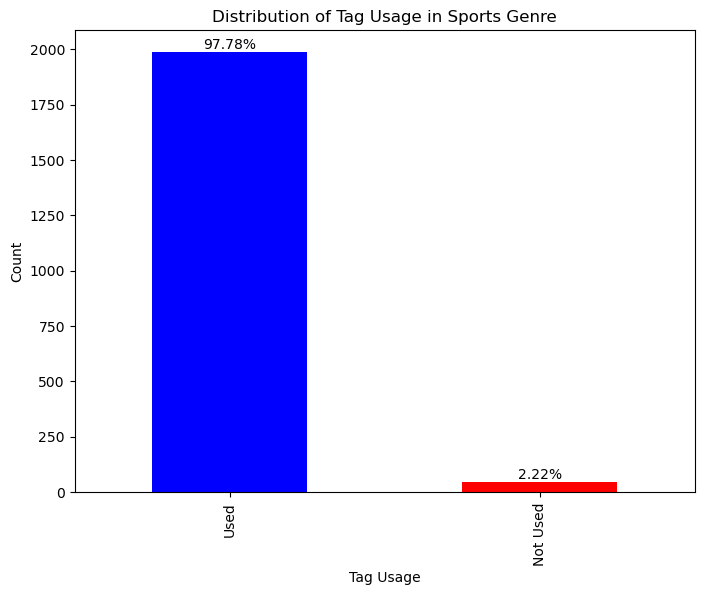

In [27]:

tag_usage_counts = dfSport['TagUsage'].value_counts()


tag_usage_percentages = tag_usage_counts / tag_usage_counts.sum() * 100


custom_colors = ['blue', 'red']

plt.figure(figsize=(8, 6))
ax = tag_usage_counts.plot(kind='bar', color=custom_colors)
plt.title('Distribution of Tag Usage in Sports Genre')
plt.xlabel('Tag Usage')
plt.ylabel('Count')

for i, v in enumerate(tag_usage_counts):
    ax.text(i, v, f'{tag_usage_percentages[i]:.2f}%', ha='center', va='bottom')

# Show the chart
plt.show()

People & Blogs

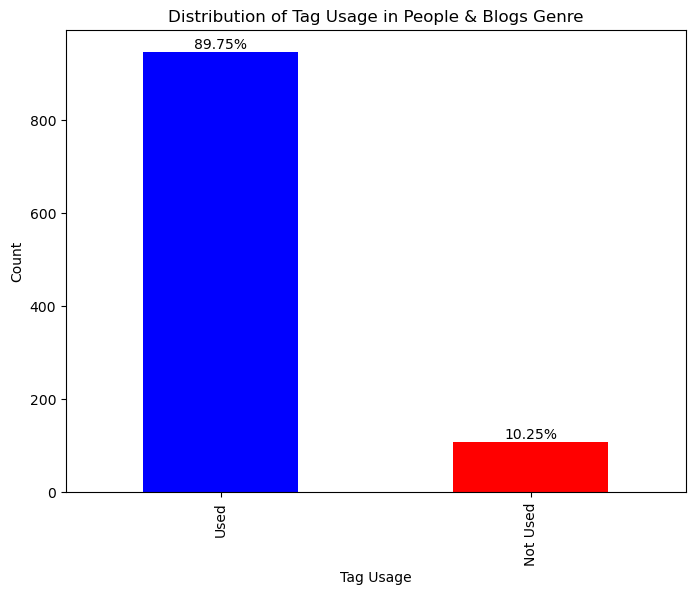

In [28]:
# Count the frequencies of each unique value in the 'TagUsage' column
tag_usage_counts = dfPpl['TagUsage'].value_counts()

# Calculate the percentage for each 'TagUsage' category
tag_usage_percentages = tag_usage_counts / tag_usage_counts.sum() * 100

# Define custom colors for each 'TagUsage'
custom_colors = ['blue', 'red']

# Create a bar chart with custom colors and annotations for percentages
plt.figure(figsize=(8, 6))
ax = tag_usage_counts.plot(kind='bar', color=custom_colors)
plt.title('Distribution of Tag Usage in People & Blogs Genre')
plt.xlabel('Tag Usage')
plt.ylabel('Count')

# Annotate the bars with percentages
for i, v in enumerate(tag_usage_counts):
    ax.text(i, v, f'{tag_usage_percentages[i]:.2f}%', ha='center', va='bottom')

# Show the chart
plt.show()

Games

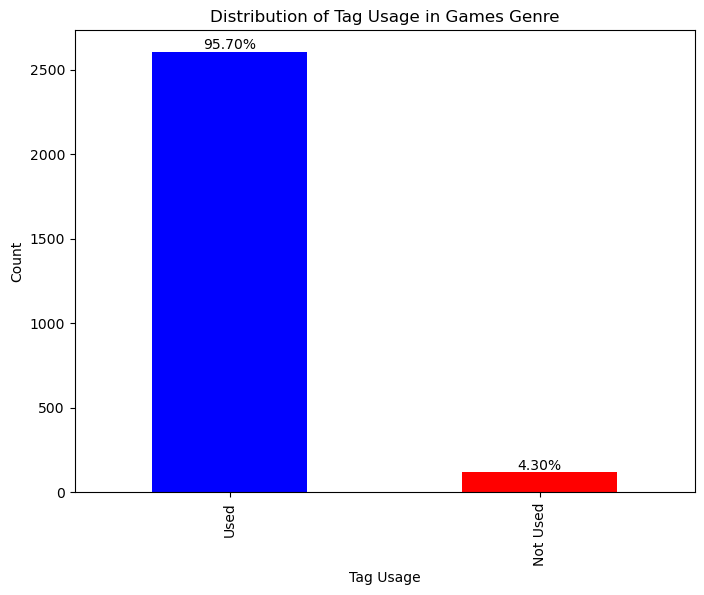

In [29]:
# Count the frequencies of each unique value in the 'TagUsage' column
tag_usage_counts = dfGame['TagUsage'].value_counts()

# Calculate the percentage for each 'TagUsage' category
tag_usage_percentages = tag_usage_counts / tag_usage_counts.sum() * 100

# Define custom colors for each 'TagUsage'
custom_colors = ['blue', 'red']

# Create a bar chart with custom colors and annotations for percentages
plt.figure(figsize=(8, 6))
ax = tag_usage_counts.plot(kind='bar', color=custom_colors)
plt.title('Distribution of Tag Usage in Games Genre')
plt.xlabel('Tag Usage')
plt.ylabel('Count')

# Annotate the bars with percentages
for i, v in enumerate(tag_usage_counts):
    ax.text(i, v, f'{tag_usage_percentages[i]:.2f}%', ha='center', va='bottom')

# Show the chart
plt.show()

**Finding the correlation between tags and views, likes, dislikes**

Sports

In [30]:
filtered_df = dfSport[(dfSport['top_10_percent_count'] != 0)]

correlation_view = filtered_df['view_count'].corr(filtered_df['top_10_percent_count'])
correlation_like = filtered_df['top_10_percent_count'].corr(filtered_df['likes'])
correlation_dislike = filtered_df['top_10_percent_count'].corr(filtered_df['dislikes'])

print(f"Correlation between 'top_10_percent_count' and 'view_count': {correlation_view:.2f}")
print(f"Correlation between 'top_10_percent_count' and 'likes': {correlation_like:.2f}")
print(f"Correlation between 'top_10_percent_count' and 'dislikes': {correlation_dislike:.2f}")

Correlation between 'top_10_percent_count' and 'view_count': 0.19
Correlation between 'top_10_percent_count' and 'likes': 0.21
Correlation between 'top_10_percent_count' and 'dislikes': 0.12


Games

In [31]:
filtered_df = dfGame[(dfGame['top_10_percent_count'] != 0)]

correlation_view = filtered_df['view_count'].corr(filtered_df['top_10_percent_count'])
correlation_like = filtered_df['top_10_percent_count'].corr(filtered_df['likes'])
correlation_dislike = filtered_df['top_10_percent_count'].corr(filtered_df['dislikes'])

print(f"Correlation between 'top_10_percent_count' and 'view_count': {correlation_view:.2f}")
print(f"Correlation between 'top_10_percent_count' and 'likes': {correlation_like:.2f}")
print(f"Correlation between 'top_10_percent_count' and 'dislikes': {correlation_dislike:.2f}")

Correlation between 'top_10_percent_count' and 'view_count': 0.09
Correlation between 'top_10_percent_count' and 'likes': 0.10
Correlation between 'top_10_percent_count' and 'dislikes': 0.05


People & Blogs

In [32]:
filtered_df = dfPpl[(dfPpl['top_10_percent_count'] != 0)]

correlation_view = filtered_df['view_count'].corr(filtered_df['top_10_percent_count'])
correlation_like = filtered_df['top_10_percent_count'].corr(filtered_df['likes'])
correlation_dislike = filtered_df['top_10_percent_count'].corr(filtered_df['dislikes'])

print(f"Correlation between 'top_10_percent_count' and 'view_count': {correlation_view:.2f}")
print(f"Correlation between 'top_10_percent_count' and 'likes': {correlation_like:.2f}")
print(f"Correlation between 'top_10_percent_count' and 'dislikes': {correlation_dislike:.2f}")

Correlation between 'top_10_percent_count' and 'view_count': 0.12
Correlation between 'top_10_percent_count' and 'likes': 0.13
Correlation between 'top_10_percent_count' and 'dislikes': -0.01


In [33]:
## Corelation between Tags and reaction (Likes and Dislikes)
correlation_GameTagLikeDislike = dfGame['top_10_percent_count'].corr(dfGame['LikesDislikeSum'])

correlation_SportTagLikeDislike = dfSport['top_10_percent_count'].corr(dfSport['LikesDislikeSum'])

correlation_PeopleTagLikeDislike = dfPpl['top_10_percent_count'].corr(dfPpl['LikesDislikeSum'])

# Display the correlations
print(f"Correlation between 'top_10_percent_count' and 'LikesDislikeSum	': {correlation_GameTagLikeDislike:.2f}")
print(f"Correlation between 'top_10_percent_count' and 'LikesDislikeSum	': {correlation_SportTagLikeDislike:.2f}")
print(f"Correlation between 'top_10_percent_count' and 'LikesDislikeSum	': {correlation_PeopleTagLikeDislike:.2f}")


Correlation between 'top_10_percent_count' and 'LikesDislikeSum	': 0.10
Correlation between 'top_10_percent_count' and 'LikesDislikeSum	': 0.21
Correlation between 'top_10_percent_count' and 'LikesDislikeSum	': 0.12


Since there is no deep correlation between the videos' tags and the views likes and dislikes, the videos' success is **not** dependent by this research

## Exploring Relationship in Videos by the Video Title ##

**Finding the Correlation Between Video Title Lenght and View Count**

In [34]:
# Add a new column for title length
df['title_length'] = df['title'].apply(len)

# Calculate the correlation between title length and view count
correlation = df['title_length'].corr(df['view_count'])

# Print the correlation value
print(f"Correlation between Title Length and View Count: {correlation:.2f}")

Correlation between Title Length and View Count: -0.05


There is **no** correlation

**Resetting All Dataframes**

In [35]:
dfSport = df[df['categoryName'] == 'Sports']

dfSport=dfSport.drop(['comment_count', 'ratings_disabled','description','publishedAt','trending_date','comments_disabled','tags'], axis=1)

dfSport.head(2)

title  \
40  Shannon reacts to Kyle Kuzma's game-winning sh...   
43   Giannis Gets Ejected After Headbutting Mo Wagner   

                    channelTitle  view_count  likes  dislikes categoryName  \
40  Skip and Shannon: UNDISPUTED      540613   7155       308       Sports   
43               Bleacher Report      756814   8278       331       Sports   

                                        cleaned_title  title_length  
40  shannon reacts kyle kuzmas gamewinning shot im...           100  
43         giannis gets ejected headbutting mo wagner            48

**Counting All Words From The Cleaned Title Colum**

In [36]:
dfSport['LikesDislikeSum']=dfSport['likes'] + dfSport['dislikes']

In [37]:
column_list = dfSport['cleaned_title'].tolist()

column_list = [string.split() for string in column_list]

flat_list = [word for sublist in column_list for word in sublist]

word_counts = Counter(flat_list)


**Creating Dataframes Showing the Frequency of Words**

In [38]:
# Create a DataFrame to store the tag names and their frequencies
title_frequencies_df = pd.DataFrame(word_counts.items(), columns=['Title', 'Frequency'])

# Sort the DataFrame by frequency in descending order
title_frequencies_df = title_frequencies_df.sort_values(by='Frequency', ascending=False)

# Reset the index of the DataFrame
title_frequencies_df = title_frequencies_df.reset_index(drop=True)
title_frequencies_df

Title  Frequency
0      highlights        777
1              vs        586
2            game        261
3            full        218
4          sports        191
...           ...        ...
3889    lightning          1
3890       airbnb          1
3891     workshop          1
3892        raise          1
3893  anniversary          1

[3894 rows x 2 columns]

**Determining the top 10% Most Frequent Title Words and Getting Rid of Frequencies of 1**

In [39]:
# Calculate the total number of unique tags
total_unique_title = len(title_frequencies_df)

# Calculate the top 10% threshold
top_10_percent = int(total_unique_title * 0.10)

# Filter the tags to get the top 10% most frequent tags
top_10_percent_titles = title_frequencies_df.head(top_10_percent)

# Remove tags with a frequency of 1
top_10_percent_titles = top_10_percent_titles[top_10_percent_titles['Frequency'] != 1]

# Reset the index of the DataFrame
top_10_percent_titles = top_10_percent_titles.reset_index(drop=True)
top_10_percent_titles

Title  Frequency
0    highlights        777
1            vs        586
2          game        261
3          full        218
4        sports        191
..          ...        ...
384        back          8
385   penalties          8
386          go          8
387        epic          8
388         lee          8

[389 rows x 2 columns]

**Determining if a Top 10% Word Has Been Used**

In [40]:
# Create a set of the top 10% most frequent words
top_10_percent_words_set = set(top_10_percent_titles['Title'])

# Function to check if any word from the top 10% is present in the cleaned titles
def contains_top_words(title):
    title = title.lower()  
    words = title.split()
    for word in words:
        if word in top_10_percent_words_set:
            return 'Used'
    return 'Not Used'

# Apply the function to the 'cleaned_title' column of the DataFrame
dfSport['top_words_usage'] = dfSport['cleaned_title'].apply(contains_top_words)

# Count the occurrences of "Used" and "Not Used" in the 'top_words_usage' column
usage_counts = dfSport['top_words_usage'].value_counts()

# Display the counts
print(usage_counts)

Used        2004
Not Used      64
Name: top_words_usage, dtype: int64


**Counting the Frequencies Used of the Top 10%**

In [41]:
def count_top_words(title):
    count = 0
    words = title.split()
    for word in words:
        if word in top_10_percent_titles['Title'].values:
            count += 1
    return count

dfSport['top_10_percent_count'] = dfSport['cleaned_title'].apply(count_top_words)
dfSport.head(4)

title  \
40  Shannon reacts to Kyle Kuzma's game-winning sh...   
43   Giannis Gets Ejected After Headbutting Mo Wagner   
47  TRAIL BLAZERS at MAVERICKS | FULL GAME HIGHLIG...   
65  'Don't mess with Dame Dolla' - Stephen A. reac...   

                    channelTitle  view_count  likes  dislikes categoryName  \
40  Skip and Shannon: UNDISPUTED      540613   7155       308       Sports   
43               Bleacher Report      756814   8278       331       Sports   
47                           NBA      937569  10160       405       Sports   
65                          ESPN      791489  13242       325       Sports   

                                        cleaned_title  title_length  \
40  shannon reacts kyle kuzmas gamewinning shot im...           100   
43         giannis gets ejected headbutting mo wagner            48   
47  trail blazers mavericks full game highlights a...            67   
65  dont mess dame dolla stephen reacts lillards b...            96   

    LikesDislikeSum top_words_usage  top_10_percent_count  
40             7463            Used                     7  
43             8609            Used                     2  
47            10565            Used                     7  
65            13567            Used                     6

**Creating a Graph to See Theq Frequency of Words**

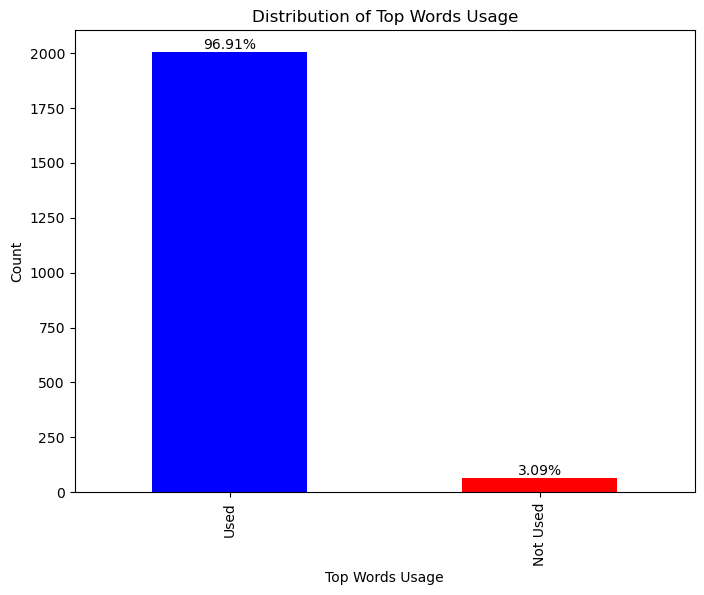

In [42]:
# Calculate the frequencies of 'top_words_usage' values
top_words_usage_counts = dfSport['top_words_usage'].value_counts()

# Calculate the percentage for each 'top_words_usage' category
top_words_usage_percentages = top_words_usage_counts / top_words_usage_counts.sum() * 100

# Define custom colors for the bars
custom_colors = ['blue', 'red']

# Create a bar chart with custom colors and annotations for percentages
plt.figure(figsize=(8, 6))
ax = top_words_usage_counts.plot(kind='bar', color=custom_colors)
plt.title('Distribution of Top Words Usage')
plt.xlabel('Top Words Usage')
plt.ylabel('Count')

# Annotate the bars with percentages
for i, v in enumerate(top_words_usage_counts):
    ax.text(i, v, f'{top_words_usage_percentages[i]:.2f}%', ha='center', va='bottom')

# Show the chart
plt.show()

**Finding the Correlation Between the Top 10% Most Frequent Words and Views, Likes, Dislikes**

In [43]:


correlation_view = dfSport['top_10_percent_count'].corr(dfSport['view_count'])
correlation_likes = dfSport['top_10_percent_count'].corr(dfSport['likes'])
correlation_dislikes = dfSport['top_10_percent_count'].corr(dfSport['dislikes'])
correlation_length = dfSport['title_length'].corr(dfSport['dislikes'])

# Display the correlations
print(f"Correlation between 'top_10_percent_count' and 'view_count': {correlation_view:.2f}")
print(f"Correlation between 'top_10_percent_count' and 'likes': {correlation_likes:.2f}")
print(f"Correlation between 'top_10_percent_count' and 'dislikes': {correlation_dislikes:.2f}")


Correlation between 'top_10_percent_count' and 'view_count': -0.01
Correlation between 'top_10_percent_count' and 'likes': -0.20
Correlation between 'top_10_percent_count' and 'dislikes': -0.01


In [44]:

correlation_SportTitleLikeDislike = dfSport['top_10_percent_count'].corr(dfSport['LikesDislikeSum'])

# Display the correlations

print(f"Correlation between 'top_10_percent_count' and 'LikesDislikeSum': {correlation_SportTitleLikeDislike:.2f}")


Correlation between 'top_10_percent_count' and 'LikesDislikeSum': -0.19


Ther is **no** Correlation

**Most Watched Channels**

In [45]:

dfsports_sorted = dfSport.sort_values(by='view_count', ascending=False)


total_rows = len(dfsports_sorted)


top_10_percent = int(total_rows * 0.10)


top_10_percent_channels = dfsports_sorted.head(top_10_percent)


In [46]:
top_10_percent_channels

title  \
22803  Pandya's power seals series win for India with...   
75400  India Claim Thrilling Win! | England v India -...   
22606  India take 1-0 lead after dramatic T20 opener ...   
79605  India Win To Take 2-1 Lead | England v India -...   
22217  India hold their nerve to win ODI epic in Canb...   
...                                                  ...   
59596  Mayweather vs. Paul: Post-Fight Press Conferen...   
1465   Rey & Dominik Mysterio fight off Seth Rollins ...   
25037  LAKERS at SUNS | FULL GAME HIGHLIGHTS | Decemb...   
74995  Rigondeaux vs Casimero HIGHLIGHTS: August 14, ...   
47794  LAKERS at NETS | FULL GAME HIGHLIGHTS | April ...   

                        channelTitle  view_count   likes  dislikes  \
22803                 cricket.com.au    26361663  637050     16679   
75400  England & Wales Cricket Board    20343912  603307     12391   
22606                 cricket.com.au    18669526  406897     14006   
79605  England & Wales Cricket Board    18020798  430703     12117   
22217                 cricket.com.au    17895564  354313     14621   
...                              ...         ...     ...       ...   
59596                SHOWTIME Sports     2468508   38505      1719   
1465                             WWE     2457925   62763      2112   
25037                            NBA     2457778   23779       804   
74995       Premier Boxing Champions     2453691   19294      1599   
47794                            NBA     2449511   24455      1193   

      categoryName                                      cleaned_title  \
22803       Sports  pandyas power seals series win india epic chas...   
75400       Sports  india claim thrilling win england v india day ...   
22606       Sports   india take lead dramatic opener dettol ti series   
79605       Sports  india win take lead england v india day highli...   
22217       Sports  india hold nerve win odi epic canberra dettol ...   
...            ...                                                ...   
59596       Sports  mayweather vs paul postfight press conference ...   
1465        Sports  rey dominik mysterio fight seth rollins murphy...   
25037       Sports          lakers suns full game highlights december   
74995       Sports  rigondeaux vs casimero highlights august pbc s...   
47794       Sports             lakers nets full game highlights april   

       title_length  LikesDislikeSum top_words_usage  top_10_percent_count  
22803            83           653729            Used                     5  
75400            93           615698            Used                     8  
22606            71           420903            Used                     3  
79605            93           442820            Used                    10  
22217            75           368934            Used                     4  
...             ...              ...             ...                   ...  
59596            63            40224            Used                     8  
1465             74            64875            Used                     3  
25037            57            24583            Used                     6  
74995            68            20893            Used                     5  
47794            54            25648            Used                     5  

[206 rows x 11 columns]

In [47]:
channel_stats = dfSport.groupby('channelTitle').agg({
    'view_count': 'sum',
    'dislikes': 'sum',
    'likes': 'sum'
    
}).reset_index()

# Display the resulting DataFrame
channel_stats

channelTitle  view_count  dislikes    likes
0                             2HYPE     5086915      5373   308980
1               ACC Digital Network      355883       146     2978
2                              AFTV     3298781      7406   135123
3                   ARMWRESTLING TV      575673       241    20246
4    Alabama Crimson Tide on AL.com      287722       104     3609
..                              ...         ...       ...      ...
331                  cricket.com.au    92416132     65230  2318598
332                     dodgerfilms     1236378       482    38562
333                       kenanK TV      251918       900      953
334                      nbagleague     1519729       431    14368
335                       nick briz     2062582     14585   105970

[336 rows x 4 columns]

In [48]:
channel_stats['likesdislikedsum']=channel_stats['likes'] + channel_stats['dislikes']
channel_stats['ldsumdivviews']=channel_stats['likesdislikedsum'] / channel_stats['view_count']
channel_stats['likestotal']=channel_stats['likes'] / channel_stats['likesdislikedsum']
channel_stats['dislikestotal']=channel_stats['dislikes'] / channel_stats['likesdislikedsum']
channel_stats.head(100)

channelTitle  view_count  dislikes   likes  \
0                            2HYPE     5086915      5373  308980   
1              ACC Digital Network      355883       146    2978   
2                             AFTV     3298781      7406  135123   
3                  ARMWRESTLING TV      575673       241   20246   
4   Alabama Crimson Tide on AL.com      287722       104    3609   
..                             ...         ...       ...     ...   
95                        FloBikes     1650642       539    7666   
96                Foolish Baseball      262902       140   18735   
97                  Football Daily      254862       296    6566   
98                  Fore Play Golf      338946        71    6073   
99                    Fox Deportes       86848        68     422   

    likesdislikedsum  ldsumdivviews  likestotal  dislikestotal  
0             314353       0.061796    0.982908       0.017092  
1               3124       0.008778    0.953265       0.046735  
2             142529       0.043207    0.948039       0.051961  
3              20487       0.035588    0.988236       0.011764  
4               3713       0.012905    0.971990       0.028010  
..               ...            ...         ...            ...  
95              8205       0.004971    0.934308       0.065692  
96             18875       0.071795    0.992583       0.007417  
97              6862       0.026924    0.956864       0.043136  
98              6144       0.018127    0.988444       0.011556  
99               490       0.005642    0.861224       0.138776  

[100 rows x 8 columns]

In [49]:
correlation_viewlike = channel_stats['likes'].corr(channel_stats['view_count'])

# Display the correlations
print(f"Correlation between 'top_10_percent_count' and 'view_count': {correlation_viewlike:.2f}")


Correlation between 'top_10_percent_count' and 'view_count': 0.80


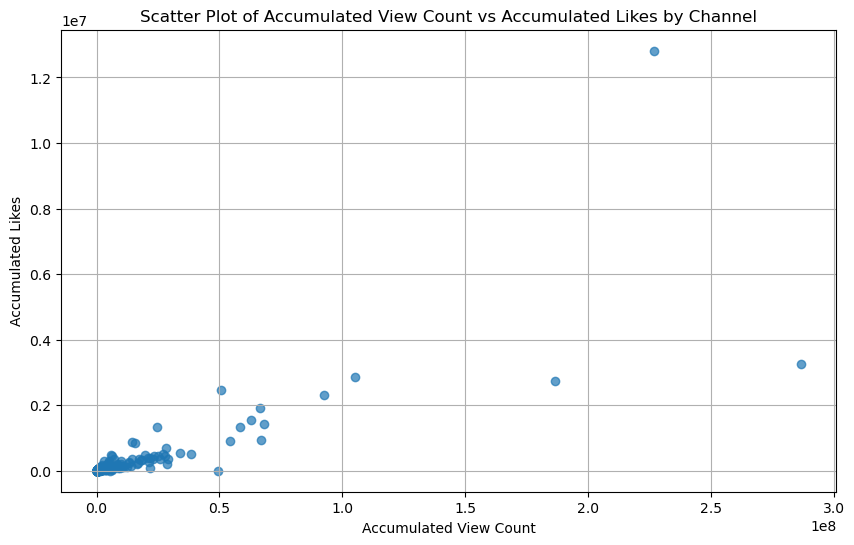

Correlation between 'view_count' and 'likes': 0.80


In [50]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(channel_stats['view_count'], channel_stats['likes'], alpha=0.7)
plt.title('Scatter Plot of Accumulated View Count vs Accumulated Likes by Channel')
plt.xlabel('Accumulated View Count')
plt.ylabel('Accumulated Likes')
plt.grid(True)
plt.show()

# Calculate the correlation coefficient
correlation = channel_stats['view_count'].corr(channel_stats['likes'])
print(f"Correlation between 'view_count' and 'likes': {correlation:.2f}")

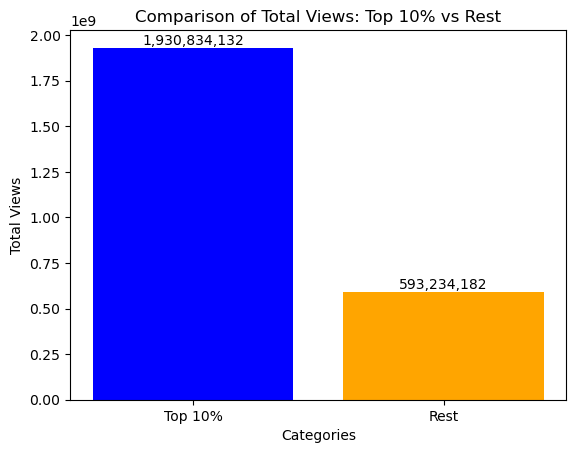

In [51]:
# Calculate the total views for each channel
channel_stats['total_views'] = channel_stats['view_count'] + channel_stats['dislikes'] + channel_stats['likes']

# Calculate the top 10 percent threshold
top_10_percent_threshold = channel_stats['total_views'].quantile(0.9)

# Create a column indicating whether each channel is in the top 10 percent
channel_stats['top_10_percent'] = channel_stats['total_views'] >= top_10_percent_threshold

# Calculate the total views for the top 10 percent channels
total_views_top_10_percent = channel_stats[channel_stats['top_10_percent']]['total_views'].sum()

# Calculate the total views for the rest of the channels
total_views_rest = channel_stats[~channel_stats['top_10_percent']]['total_views'].sum()

# Create a bar chart to compare total views
labels = ['Top 10%', 'Rest']
total_views = [total_views_top_10_percent, total_views_rest]

fig, ax = plt.subplots()

bars = ax.bar(labels, total_views, color=['blue', 'orange'])

# Annotate the bars with the total views
for bar, total_views in zip(bars, total_views):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{total_views:,}', ha='center', va='bottom')

plt.title('Comparison of Total Views: Top 10% vs Rest')
plt.xlabel('Categories')
plt.ylabel('Total Views')
plt.show()

# Drop the temporary columns
channel_stats.drop(['total_views', 'top_10_percent'], axis=1, inplace=True)

**Exploring Enabled/Disabled Comments on Videos**

Creating dfs for enabled and disabled videos

In [52]:
df = pd.read_csv(r'c:\YoutubeProject\US_youtube_trending_data.csv')

# Remove the 'thumbnail_link' column
df.drop('thumbnail_link', axis=1, inplace=True)

# Remove the 'video_id' column
df.drop('video_id', axis=1, inplace=True)

# Remove the 'channelId' column
df.drop('channelId', axis=1, inplace=True)

df = df[(df['dislikes'] != 0) | ((df['dislikes'] == 0) & (df['likes'] == 0))]

df = df[(df['view_count'] != 0)]

df= df[df['tags']!= '[none]']

df = df.drop_duplicates(subset='title')


In [53]:



df_comments_disabled= df[df['comments_disabled'] == True]

df_comments_enabled= df[df['comments_disabled'] == False]


df_comments_disabled=df_comments_disabled.drop(['tags','channelTitle','ratings_disabled','description','publishedAt','trending_date'], axis=1)

df_comments_enabled=df_comments_enabled.drop(['tags','channelTitle','ratings_disabled','description','publishedAt','trending_date'], axis=1)

df_comments_disabled


title  categoryId  \
53      FIRST DAY IN THE NEW HOUSE! Ellie and Jared Mo...          22   
131                          AN UMBRELLA ACADEMY UNBOXING          24   
134                  LaBrant Family Baby Boy Name Reveal.          22   
242     First Day of School GRWM + Vlog | College Edit...          26   
816           IMPORTANT NEWS ABOUT ANNABELLE ‚Äú ESCAPING ‚Äú          24   
...                                                   ...         ...   
216809        FINAL FANTASY XIV: DAWNTRAIL Teaser Trailer          20   
219995            DRAGON BALL LEGENDS REVEALS ÔºÜ STUFF #30          20   
222612                 2023 DOKKAN NOW! SPECIAL (English)          20   
223392  TV„Ç¢„Éã„É°„ÄéÂë™Ë°ìÂªªÊà¶„ÄèÁ¨¨2Êúü„ÄåÊ∏ãË∞∑‰∫ãÂ§â„Äç„Éé„É≥„ÇØ„É¨„Ç∏„ÉÉ„ÉàOP„É†„Éº„Éì„ÉºÔºèOP„ÉÜ„Éº„ÉûÔºöKing G...           1   
226056            DRAGON BALL LEGENDS REVEALS ÔºÜ STUFF #31          20   

        view_count   likes  dislikes  comment_count  comments_disabled  
53          208173    8810       215              0               True  
131        1183833  127487      1588              0               True  
134        5849640  287811      5040              0               True  
242         260195   17234       213              0               True  
816         922298   33123       708              0               True  
...            ...     ...       ...            ...                ...  
216809      746517       0         0              0               True  
219995      305999       0         0              0               True  
222612      187732       0         0              0               True  
223392     4128796       0         0              0               True  
226056      159653       0         0              0               True  

[317 rows x 7 columns]

**10% Best Performing**

In [54]:

df_comments_disabled = df_comments_disabled.sort_values(by='view_count', ascending=False)

df_comments_disabled31 = df_comments_disabled.head(31)

In [55]:
#For best performing if comments are enabled

df_comments_enabled = df_comments_enabled.sort_values(by='view_count', ascending=False)

df_comments_enabled31 = df_comments_enabled.head(31)

df_comments_enabled31

title  categoryId  \
80193                                LISA - 'LALISA' M/V          10   
51     Cardi B - WAP feat. Megan Thee Stallion [Offic...          10   
55605                   BTS (Î∞©ÌÉÑÏÜåÎÖÑÎã®) 'Butter' Official MV          10   
65398               MvRyhan Funny videos #tiktok #Shorts          24   
1800                  BTS (Î∞©ÌÉÑÏÜåÎÖÑÎã®) 'Dynamite' Official MV          10   
3200     BLACKPINK - 'Ice Cream (with Selena Gomez)' M/V          10   
66791                     Oddly Satisfying Video #Shorts          22   
86622                           My hidden talent #shorts          23   
17656  Live 2020 Election Results: Joe Biden beats Do...          25   
54804                  Money Plinko Challenge! üí∞ #shorts          20   
58390    BTS (Î∞©ÌÉÑÏÜåÎÖÑÎã®) 'Butter (Hotter Remix)' Official MV          10   
76791  SPIDER-MAN: NO WAY HOME - Official Teaser Trai...          24   
56292                        EVERGLOW (ÏóêÎ≤ÑÍ∏ÄÎ°úÏö∞) - FIRST MV          10   
53612                NCT DREAM ÏóîÏãúÌã∞ ÎìúÎ¶º 'Îßõ (Hot Sauce)' MV          10   
93402                      How could I get out of it? üå≠üå≠          23   
10201                   BLACKPINK ‚Äì ‚ÄòLovesick Girls‚Äô M/V          10   
56824      JELLY FRUIT üçé CHALLENGE @BrianaSprinz #Shorts          24   
19798             BTS (Î∞©ÌÉÑÏÜåÎÖÑÎã®) 'Life Goes On' Official MV          10   
54794                      Crazy STATIC TRICK! üò® #shorts          24   
59197                   Turn into egg - Tutorial #Shorts          24   
56315      BTS (Î∞©ÌÉÑÏÜåÎÖÑÎã®) 'Butter' @ Billboard Music Awards          10   
56232  Fresh Squeezed OJ Fail #shorts Funny TikTok Pr...          24   
81599                       NCT 127 ÏóîÏãúÌã∞ 127 'Sticker' MV          10   
67391      BTS (Î∞©ÌÉÑÏÜåÎÖÑÎã®) 'Permission to Dance' Official MV          10   
93791    SPIDER-MAN: NO WAY HOME - Official Trailer (HD)          24   
85200                              aespa ÏóêÏä§Ìåå 'Savage' MV          10   
16798  2020 Election Results Live: Presidential and S...          25   
1400              BTS (Î∞©ÌÉÑÏÜåÎÖÑÎã®) 'Dynamite' Official Teaser          10   
45794                 BTS (Î∞©ÌÉÑÏÜåÎÖÑÎã®) 'Film out' Official MV          10   
56207    BTS (Î∞©ÌÉÑÏÜåÎÖÑÎã®) 'Butter' Official MV (Hotter Remix)          10   
13867  Burjkhalifa | Laxmmi Bomb | Akshay Kumar | Kia...          10   

       view_count    likes  dislikes  comment_count  comments_disabled  
80193    85890366  5921316     38624        1958529              False  
51       76805026  2820345    382578         270263              False  
55605    67111752  7110071      8998        3400291              False  
65398    59410897  1176893     39704           4850              False  
1800     57229275  7045907    165420        2314087              False  
3200     51234434  5912778    405329        1847794              False  
66791    50740092  1671219     56972           4143              False  
86622    49423130  1592335     27861           3163              False  
17656    46246802   143197     48953            288              False  
54804    43969654  1329657     42170           2756              False  
58390    43163081  5110687     33641         326077              False  
76791    41424503  2129390     10895         136941              False  
56292    41154172   718321     10950         113753              False  
53612    41105356  1727767     14578         449949              False  
93402    40945618  2366825     41185           1616              False  
10201    39363127  4746270     17513        1021283              False  
56824    38898786   966171     43134           2131              False  
19798    37570579  5177871     12125        2276126              False  
54794    37377911  1520059     48014          11589              False  
59197    36554383  1379394     32769            790              False  
56315    36233587  4002888     30568         201218              Fal

In [56]:
#Enabled
e_correlation_ViewLike = df_comments_enabled31['likes'].corr(df_comments_enabled31['view_count'])
e_correlation_ViewDislike = df_comments_enabled31['dislikes'].corr(df_comments_enabled31['view_count'])
e_correlation_LikesDislike = df_comments_enabled31['likes'].corr(df_comments_enabled31['dislikes'])

#Disabled
d_correlation_ViewLike = df_comments_disabled31['likes'].corr(df_comments_disabled31['view_count'])
d_correlation_ViewDislike = df_comments_disabled31['dislikes'].corr(df_comments_disabled31['view_count'])
d_correlation_LikesDislike = df_comments_disabled31['likes'].corr(df_comments_disabled31['dislikes'])

# Display the correlations
print('For Comments Enabled')
print(f"Correlation between 'likes' and 'view_count': {e_correlation_ViewLike:.2f}")
print(f"Correlation between 'dislikes' and 'view_count': {e_correlation_ViewDislike:.2f}")
print(f"Correlation between 'likes' and 'dislikes': {e_correlation_LikesDislike:.2f}")

print('\nFor Comments Disabled')
print(f"Correlation between 'likes' and 'view_count': {d_correlation_ViewLike:.2f}")
print(f"Correlation between 'dislikes' and 'view_count': {d_correlation_ViewDislike:.2f}")
print(f"Correlation between 'likes' and 'dislikes': {d_correlation_LikesDislike:.2f}")

For Comments Enabled
Correlation between 'likes' and 'view_count': 0.36
Correlation between 'dislikes' and 'view_count': 0.44
Correlation between 'likes' and 'dislikes': 0.25

For Comments Disabled
Correlation between 'likes' and 'view_count': 0.18
Correlation between 'dislikes' and 'view_count': 0.08
Correlation between 'likes' and 'dislikes': 0.64


In [57]:
viewsTotalDisabled = df_comments_disabled31['view_count'].sum()
viewsTotalEnabled = df_comments_enabled31['view_count'].sum()

likesTotalDisabled = df_comments_disabled31['likes'].sum()
likesTotalEnabled = df_comments_enabled31['likes'].sum()

dislikesTotalDisabled = df_comments_disabled31['dislikes'].sum()
dilikesTotalEnabled = df_comments_enabled31['dislikes'].sum()

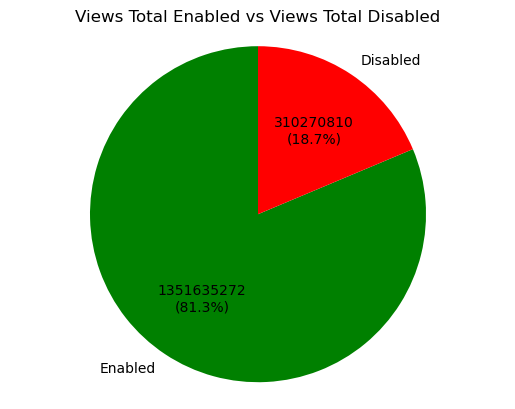

In [58]:
viewsTotalEnabled = viewsTotalEnabled
viewsTotalDisabled = viewsTotalDisabled

# Data
labels = ['Enabled', 'Disabled']
values = [viewsTotalEnabled, viewsTotalDisabled]

# Plotting the pie chart with actual values
plt.pie(values, labels=labels, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(values) / 100, p), startangle=90, colors=['green', 'red'])

# Equal aspect ratio ensures that the pie chart is circular
plt.axis('equal')

# Adding a title
plt.title('Views Total Enabled vs Views Total Disabled')

# Display the pie chart
plt.show()

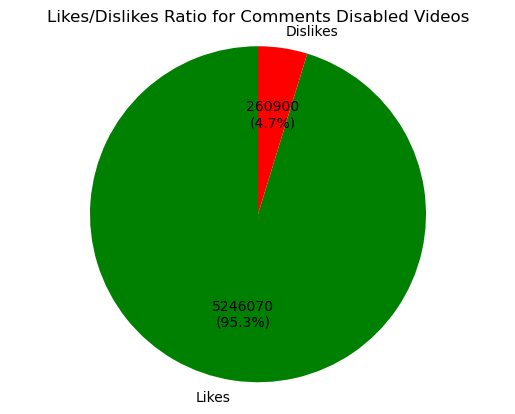

In [59]:
likesTotalDisabled = likesTotalDisabled
dislikesTotalDisabled = dislikesTotalDisabled

# Data
labels = ['Likes', 'Dislikes']
values = [likesTotalDisabled, dislikesTotalDisabled]

# Plotting the pie chart with actual values
plt.pie(values, labels=labels, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(values) / 100, p), startangle=90, colors=['green', 'red'])

# Equal aspect ratio ensures that the pie chart is circular
plt.axis('equal')

# Adding a title
plt.title('Likes/Dislikes Ratio for Comments Disabled Videos')

# Display the pie chart
plt.show()

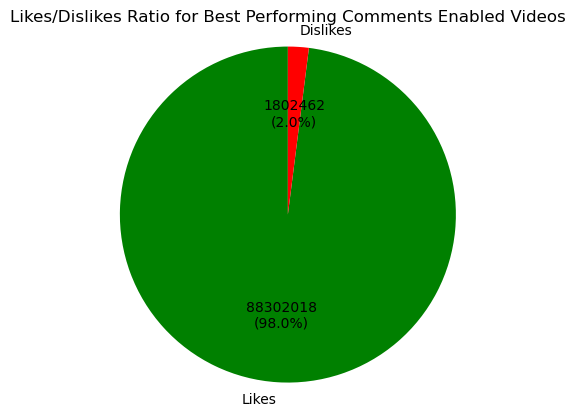

In [60]:
likesTotalEnabled = likesTotalEnabled
dilikesTotalEnabled = dilikesTotalEnabled

# Data
labels = ['Likes', 'Dislikes']
values = [likesTotalEnabled, dilikesTotalEnabled]

# Plotting the pie chart with actual values
plt.pie(values, labels=labels, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(values) / 100, p), startangle=90, colors=['green', 'red'])

# Equal aspect ratio ensures that the pie chart is circular
plt.axis('equal')

# Adding a title
plt.title('Likes/Dislikes Ratio for Best Performing Comments Enabled Videos')

# Display the pie chart
plt.show()

**10% Worst Performing**

In [61]:
df_comments_disabled31 = df_comments_disabled.tail(31)
df_comments_enabled31 = df_comments_enabled.tail(31)

In [62]:
#Enabled
e_correlation_ViewLike = df_comments_enabled31['likes'].corr(df_comments_enabled31['view_count'])
e_correlation_ViewDislike = df_comments_enabled31['dislikes'].corr(df_comments_enabled31['view_count'])
e_correlation_LikesDislike = df_comments_enabled31['likes'].corr(df_comments_enabled31['dislikes'])

#Disabled
d_correlation_ViewLike = df_comments_disabled31['likes'].corr(df_comments_disabled31['view_count'])
d_correlation_ViewDislike = df_comments_disabled31['dislikes'].corr(df_comments_disabled31['view_count'])
d_correlation_LikesDislike = df_comments_disabled31['likes'].corr(df_comments_disabled31['dislikes'])

# Display the correlations
print('For Comments Enabled')
print(f"Correlation between 'likes' and 'view_count': {e_correlation_ViewLike:.2f}")
print(f"Correlation between 'dislikes' and 'view_count': {e_correlation_ViewDislike:.2f}")
print(f"Correlation between 'likes' and 'dislikes': {e_correlation_LikesDislike:.2f}")

print('\nFor Comments Disabled')
print(f"Correlation between 'likes' and 'view_count': {d_correlation_ViewLike:.2f}")
print(f"Correlation between 'dislikes' and 'view_count': {d_correlation_ViewDislike:.2f}")
print(f"Correlation between 'likes' and 'dislikes': {d_correlation_LikesDislike:.2f}")

For Comments Enabled
Correlation between 'likes' and 'view_count': 0.22
Correlation between 'dislikes' and 'view_count': -0.06
Correlation between 'likes' and 'dislikes': 0.09

For Comments Disabled
Correlation between 'likes' and 'view_count': 0.40
Correlation between 'dislikes' and 'view_count': 0.26
Correlation between 'likes' and 'dislikes': 0.09


In [63]:
viewsTotalDisabled = df_comments_disabled31['view_count'].sum()
viewsTotalEnabled = df_comments_enabled31['view_count'].sum()

likesTotalDisabled = df_comments_disabled31['likes'].sum()
likesTotalEnabled = df_comments_enabled31['likes'].sum()

dislikesTotalDisabled = df_comments_disabled31['dislikes'].sum()
dilikesTotalEnabled = df_comments_enabled31['dislikes'].sum()

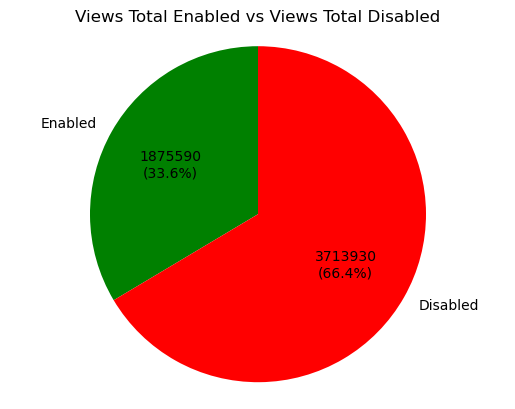

In [64]:
viewsTotalEnabled = viewsTotalEnabled
viewsTotalDisabled = viewsTotalDisabled

# Data
labels = ['Enabled', 'Disabled']
values = [viewsTotalEnabled, viewsTotalDisabled]

# Plotting the pie chart with actual values
plt.pie(values, labels=labels, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(values) / 100, p), startangle=90, colors=['green', 'red'])

# Equal aspect ratio ensures that the pie chart is circular
plt.axis('equal')

# Adding a title
plt.title('Views Total Enabled vs Views Total Disabled')

# Display the pie chart
plt.show()

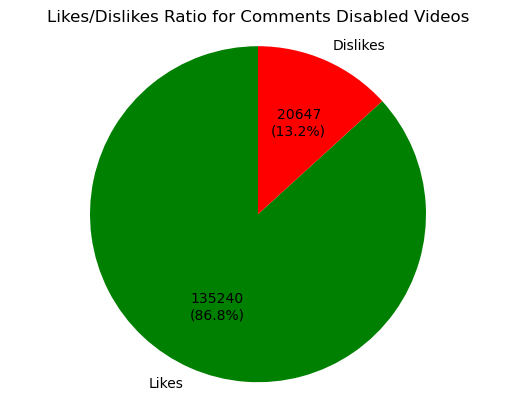

In [65]:
likesTotalDisabled = likesTotalDisabled
dislikesTotalDisabled = dislikesTotalDisabled

# Data
labels = ['Likes', 'Dislikes']
values = [likesTotalDisabled, dislikesTotalDisabled]

# Plotting the pie chart with actual values
plt.pie(values, labels=labels, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(values) / 100, p), startangle=90, colors=['green', 'red'])

# Equal aspect ratio ensures that the pie chart is circular
plt.axis('equal')

# Adding a title
plt.title('Likes/Dislikes Ratio for Comments Disabled Videos')

# Display the pie chart
plt.show()

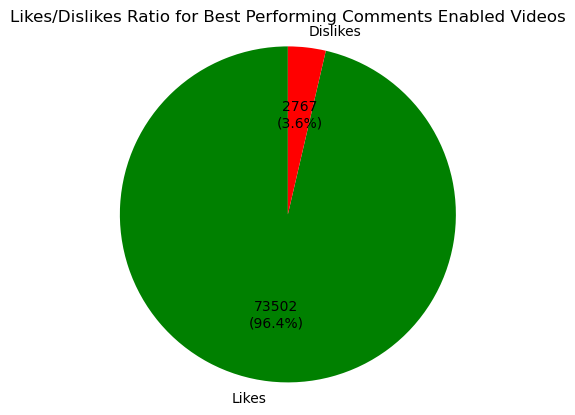

In [66]:
likesTotalEnabled = likesTotalEnabled
dilikesTotalEnabled = dilikesTotalEnabled

# Data
labels = ['Likes', 'Dislikes']
values = [likesTotalEnabled, dilikesTotalEnabled]

# Plotting the pie chart with actual values
plt.pie(values, labels=labels, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(values) / 100, p), startangle=90, colors=['green', 'red'])

# Equal aspect ratio ensures that the pie chart is circular
plt.axis('equal')

# Adding a title
plt.title('Likes/Dislikes Ratio for Best Performing Comments Enabled Videos')

# Display the pie chart
plt.show()

**Comparison Between All Disabled and Enabled Best Performing**

In [67]:
#For best performing if comments are enabled

df_comments_enabled = df_comments_enabled.sort_values(by='view_count', ascending=False)

df_comments_enabled = df_comments_enabled.head(317)

df_comments_enabled

title  categoryId  \
80193                                LISA - 'LALISA' M/V          10   
51     Cardi B - WAP feat. Megan Thee Stallion [Offic...          10   
55605                   BTS (Î∞©ÌÉÑÏÜåÎÖÑÎã®) 'Butter' Official MV          10   
65398               MvRyhan Funny videos #tiktok #Shorts          24   
1800                  BTS (Î∞©ÌÉÑÏÜåÎÖÑÎã®) 'Dynamite' Official MV          10   
...                                                  ...         ...   
46592  Marvel Studios' Loki | Official Trailer | Disney+          24   
83193  Brawl Stars: Brawl Talk - New Legendary Brawler!!          20   
74592  Sub Urban & Bella Poarch - INFERNO (Official M...          22   
35193  The Weeknd‚Äôs FULL Pepsi Super Bowl LV Halftime...          17   
50003                         $10,000 For Every Diamond!          20   

       view_count    likes  dislikes  comment_count  comments_disabled  
80193    85890366  5921316     38624        1958529              False  
51       76805026  2820345    382578         270263              False  
55605    67111752  7110071      8998        3400291              False  
65398    59410897  1176893     39704           4850              False  
1800     57229275  7045907    165420        2314087              False  
...           ...      ...       ...            ...                ...  
46592     8211861   416249      4251          22896              False  
83193     8202134   592891      7401          38969              False  
74592     8149514  1033703     14122          87116              False  
35193     8135977   470848     18621          55356              False  
50003     8134567   499152      3993          21577              False  

[317 rows x 7 columns]

In [68]:
#Enabled
e_correlation_ViewLike = df_comments_enabled['likes'].corr(df_comments_enabled['view_count'])
e_correlation_ViewDislike = df_comments_enabled['dislikes'].corr(df_comments_enabled['view_count'])
e_correlation_LikesDislike = df_comments_enabled['likes'].corr(df_comments_enabled['dislikes'])

#Disabled
d_correlation_ViewLike = df_comments_disabled['likes'].corr(df_comments_disabled['view_count'])
d_correlation_ViewDislike = df_comments_disabled['dislikes'].corr(df_comments_disabled['view_count'])
d_correlation_LikesDislike = df_comments_disabled['likes'].corr(df_comments_disabled['dislikes'])

# Display the correlations
print('For Comments Enabled')
print(f"Correlation between 'likes' and 'view_count': {e_correlation_ViewLike:.2f}")
print(f"Correlation between 'dislikes' and 'view_count': {e_correlation_ViewDislike:.2f}")
print(f"Correlation between 'likes' and 'dislikes': {e_correlation_LikesDislike:.2f}")

print('\nFor Comments Disabled')
print(f"Correlation between 'likes' and 'view_count': {d_correlation_ViewLike:.2f}")
print(f"Correlation between 'dislikes' and 'view_count': {d_correlation_ViewDislike:.2f}")
print(f"Correlation between 'likes' and 'dislikes': {d_correlation_LikesDislike:.2f}")

For Comments Enabled
Correlation between 'likes' and 'view_count': 0.56
Correlation between 'dislikes' and 'view_count': 0.49
Correlation between 'likes' and 'dislikes': 0.36

For Comments Disabled
Correlation between 'likes' and 'view_count': 0.54
Correlation between 'dislikes' and 'view_count': 0.46
Correlation between 'likes' and 'dislikes': 0.70


In [69]:
viewsTotalDisabled = df_comments_disabled['view_count'].sum()
viewsTotalEnabled = df_comments_enabled['view_count'].sum()

likesTotalDisabled = df_comments_disabled['likes'].sum()
likesTotalEnabled = df_comments_enabled['likes'].sum()

dislikesTotalDisabled = df_comments_disabled['dislikes'].sum()
dilikesTotalEnabled = df_comments_enabled['dislikes'].sum()

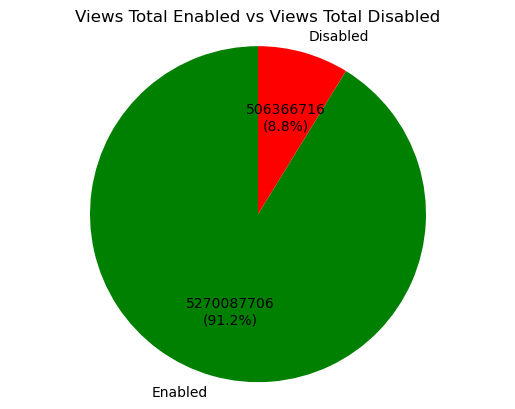

In [70]:
viewsTotalEnabled = viewsTotalEnabled
viewsTotalDisabled = viewsTotalDisabled

# Data
labels = ['Enabled', 'Disabled']
values = [viewsTotalEnabled, viewsTotalDisabled]

# Plotting the pie chart with actual values
plt.pie(values, labels=labels, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(values) / 100, p), startangle=90, colors=['green', 'red'])

# Equal aspect ratio ensures that the pie chart is circular
plt.axis('equal')

# Adding a title
plt.title('Views Total Enabled vs Views Total Disabled')

# Display the pie chart
plt.show()

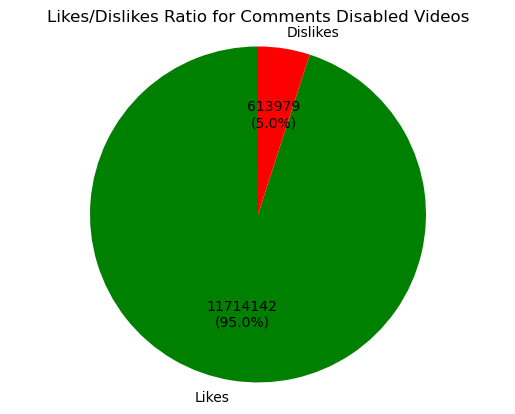

In [71]:
likesTotalDisabled = likesTotalDisabled
dislikesTotalDisabled = dislikesTotalDisabled

# Data
labels = ['Likes', 'Dislikes']
values = [likesTotalDisabled, dislikesTotalDisabled]

# Plotting the pie chart with actual values
plt.pie(values, labels=labels, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(values) / 100, p), startangle=90, colors=['green', 'red'])

# Equal aspect ratio ensures that the pie chart is circular
plt.axis('equal')

# Adding a title
plt.title('Likes/Dislikes Ratio for Comments Disabled Videos')

# Display the pie chart
plt.show()

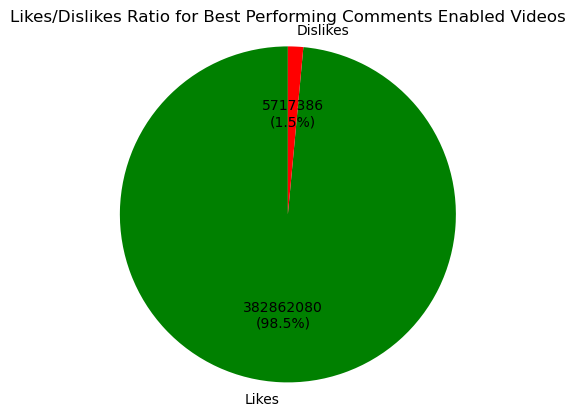

In [72]:
likesTotalEnabled = likesTotalEnabled
dilikesTotalEnabled = dilikesTotalEnabled

# Data
labels = ['Likes', 'Dislikes']
values = [likesTotalEnabled, dilikesTotalEnabled]

# Plotting the pie chart with actual values
plt.pie(values, labels=labels, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(values) / 100, p), startangle=90, colors=['green', 'red'])

# Equal aspect ratio ensures that the pie chart is circular
plt.axis('equal')

# Adding a title
plt.title('Likes/Dislikes Ratio for Best Performing Comments Enabled Videos')

# Display the pie chart
plt.show()

**Worst Performing**

In [73]:
##For worst performing comments enabled
df_comments_enabled= df[df['comments_disabled'] == False]

df_comments_enabled=df_comments_enabled.drop(['tags','channelTitle','ratings_disabled','description','publishedAt','trending_date'], axis=1)

df_comments_enabled = df_comments_enabled.sort_values(by='view_count', ascending=False)

df_comments_enabled = df_comments_enabled.tail(317)

df_comments_enabled

title  categoryId  \
93628  ZLaner BANNED From Halo Infinite, Battle Pass ...          20   
45420  Did the 49ers Just Hold the Most Honest Press ...          17   
43412          Quadeca - Sisyphus (Official Music Video)          10   
6638   Answering your RTX 3080 questions! - Probing P...          28   
19457  Harden plus KD & Kyrie won't work, Schr√∂der to...          17   
...                                                  ...         ...   
59624           Mercedes AMG GT53 Cupholder Test #shorts           2   
28421  NEVER Before Seen Video INSIDE The BENT Pyrami...          24   
1152   MMA Pros React to Chito Vera TKO Sean O'Malley...          17   
1095   Opry Livestream - Luke Bryan, Darius Rucker, &...          10   
12869  iPhone 12 and iPhone 12 Pro!  Can ANYTHING Els...          28   

       view_count  likes  dislikes  comment_count  comments_disabled  
93628      125368   3053       186            940              False  
45420      125093   2716        71            483              False  
43412      124963  22440       242           3432              False  
6638       124933   7209       133            668              False  
19457      124904   1361        67            399              False  
...           ...    ...       ...            ...                ...  
59624       50335   4288       234            202              False  
28421       48325   7531       147           1700              False  
1152        47709    393        47            618              False  
1095        44693    727         8             28              False  
12869       38510   1249        99            326              False  

[317 rows x 7 columns]

In [74]:
viewsTotalEnabled = df_comments_enabled['view_count'].sum()
likesTotalEnabled = df_comments_enabled['likes'].sum()
dilikesTotalEnabled = df_comments_enabled['dislikes'].sum()

In [75]:
viewsTotalEnabled

32172480

In [76]:
print('For Comments Enabled')
print(f"Correlation between 'likes' and 'view_count': {e_correlation_ViewLike:.2f}")
print(f"Correlation between 'dislikes' and 'view_count': {e_correlation_ViewDislike:.2f}")
print(f"Correlation between 'likes' and 'dislikes': {e_correlation_LikesDislike:.2f}")


For Comments Enabled
Correlation between 'likes' and 'view_count': 0.56
Correlation between 'dislikes' and 'view_count': 0.49
Correlation between 'likes' and 'dislikes': 0.36


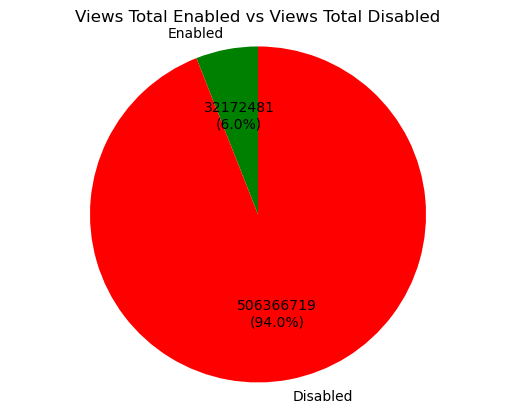

In [77]:
viewsTotalEnabled = viewsTotalEnabled
viewsTotalDisabled = viewsTotalDisabled

# Data
labels = ['Enabled', 'Disabled']
values = [viewsTotalEnabled, viewsTotalDisabled]

# Plotting the pie chart with actual values
plt.pie(values, labels=labels, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(values) / 100, p), startangle=90, colors=['green', 'red'])

# Equal aspect ratio ensures that the pie chart is circular
plt.axis('equal')

# Adding a title
plt.title('Views Total Enabled vs Views Total Disabled')

# Display the pie chart
plt.show()

Ratings Analysis

In [78]:
df_ratings_enabled= df[df['ratings_disabled'] == False]

df_ratings_disabled= df[df['ratings_disabled'] == True]


df_ratings_disabled=df_ratings_disabled.drop(['comments_disabled','description','publishedAt','trending_date'], axis=1)

df_ratings_enabled=df_ratings_enabled.drop(['comments_disabled','description','publishedAt','trending_date'], axis=1)

df_ratings_enabled

title  \
0                     I ASKED HER TO BE MY GIRLFRIEND...   
1      Apex Legends | Stories from the Outlands ‚Äì ‚ÄúTh...   
2      I left youtube for a month and THIS is what ha...   
3      XXL 2020 Freshman Class Revealed - Official An...   
4      Ultimate DIY Home Movie Theater for The LaBran...   
...                                                  ...   
98457                             END OF VAN LIFE AFRICA   
98462  3 FOODS to TRY before you DIE: Irish Edition #...   
98465                                    Vanilla Extract   
98467                          So I Wrote A Kids Book..üìö   
98484                    Severe storms turn deadly | GMA   

               channelTitle  categoryId  \
0                  Brawadis          22   
1              Apex Legends          20   
2             jacksepticeye          24   
3                       XXL          10   
4                  Mr. Kate          26   
...                     ...         ...   
98457           Eamon & Bec          19   
98462         Jorden Tually          19   
98465       Nick DiGiovanni          22   
98467        Peet Montzingo          22   
98484  Good Morning America          24   

                                                    tags  view_count   likes  \
0      brawadis|prank|basketball|skits|ghost|funny vi...     1514614  156908   
1      Apex Legends|Apex Legends characters|new Apex ...     2381688  146739   
2      jacksepticeye|funny|funny meme|memes|jacksepti...     2038853  353787   
3      xxl freshman|xxl freshmen|2020 xxl freshman|20...      496771   23251   
4      The LaBrant Family|DIY|Interior Design|Makeove...     1123889   45802   
...                                                  ...         ...     ...   
98457  van life|living in a van|vanlife|eamon and bec...      345014   21361   
98462                                      jorden tually      183570    8684   
98465                                             [None]      634395   72470   
98467  peet montzingo|monzingo|mozingo|pete|mom|tikto...     1221491   96057   
98484  Kentucky|Severe|condition|disaster|emergency|e...      897819    5006   

       dislikes  comment_count  ratings_disabled  
0          5855          35313             False  
1          2794          16549             False  
2          2628          40221             False  
3          1856           7647             False  
4           964           2196             False  
...         ...            ...               ...  
98457       198           1967             False  
98462       429            175             False  
98465       663            645             False  
98467      1827            802             False  
98484       325           1745             False  

[17895 rows x 9 columns]

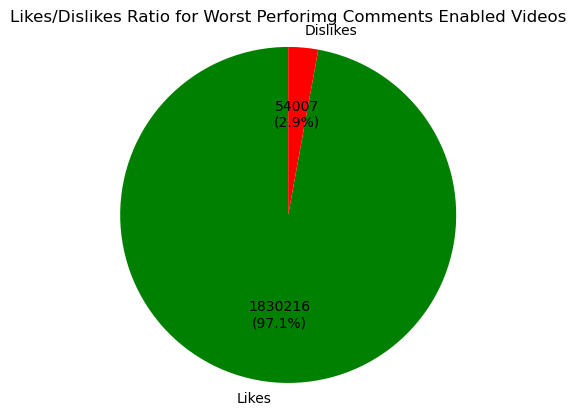

In [79]:
likesTotalEnabled = likesTotalEnabled
dilikesTotalEnabled = dilikesTotalEnabled

# Data
labels = ['Likes', 'Dislikes']
values = [likesTotalEnabled, dilikesTotalEnabled]

# Plotting the pie chart with actual values
plt.pie(values, labels=labels, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(values) / 100, p), startangle=90, colors=['green', 'red'])

# Equal aspect ratio ensures that the pie chart is circular
plt.axis('equal')

# Adding a title
plt.title('Likes/Dislikes Ratio for Worst Perforimg Comments Enabled Videos')

# Display the pie chart
plt.show()

**Ratings Analysis**

In [80]:
viewsTotalRateDisabled = df_ratings_disabled['view_count'].sum()
viewsTotalRateEnabled = df_ratings_enabled['view_count'].sum()

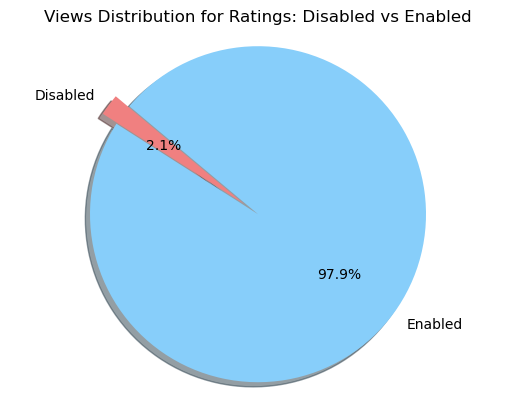

In [81]:
viewsTotalDisabled = 500
viewsTotalEnabled = 1000


labels = 'Disabled', 'Enabled'
sizes = [viewsTotalRateDisabled, viewsTotalRateEnabled]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  
plt.title('Views Distribution for Ratings: Disabled vs Enabled')
plt.show()

In [82]:
df

title  \
0                      I ASKED HER TO BE MY GIRLFRIEND...   
1       Apex Legends | Stories from the Outlands ‚Äì ‚ÄúTh...   
2       I left youtube for a month and THIS is what ha...   
3       XXL 2020 Freshman Class Revealed - Official An...   
4       Ultimate DIY Home Movie Theater for The LaBran...   
...                                                   ...   
225226  BRASIL vs. BOLIVIA [5-1] | RESUMEN | ELIMINATO...   
225609  BOLIVIA vs. ARGENTINA [0-3] | RESUMEN | ELIMIN...   
225988        Nintendo Direct 9.14.2023 - Nintendo Switch   
226043       [Ïä§Ïö∞Ìåå2] Î©îÍ∞Ä ÌÅ¨Î£® ÎØ∏ÏÖò ÎåÄÏ§ë ÌèâÍ∞Ä l Ïûº Î¶¨ÌçºÎ∏îÎ¶≠(JAM REPUBLIC)   
226056            DRAGON BALL LEGENDS REVEALS ÔºÜ STUFF #31   

                 publishedAt                channelTitle  categoryId  \
0       2020-08-11T19:20:14Z                    Brawadis          22   
1       2020-08-11T17:00:10Z                Apex Legends          20   
2       2020-08-11T16:34:06Z               jacksepticeye          24   
3       2020-08-11T16:38:55Z                         XXL          10   
4       2020-08-11T15:10:05Z                    Mr. Kate          26   
...                      ...                         ...         ...   
225226  2023-09-09T04:55:46Z                    CONMEBOL          17   
225609  2023-09-13T00:12:29Z                    CONMEBOL          17   
225988  2023-09-14T14:48:31Z         Nintendo of America          20   
226043  2023-09-12T15:16:34Z             The CHOOM (Îçî Ï∂§)          24   
226056  2023-09-12T14:00:07Z  Bandai Namco Entertainment          20   

               trending_date  \
0       2020-08-12T00:00:00Z   
1       2020-08-12T00:00:00Z   
2       2020-08-12T00:00:00Z   
3       2020-08-12T00:00:00Z   
4       2020-08-12T00:00:00Z   
...                      ...   
225226  2023-09-11T00:00:00Z   
225609  2023-09-13T00:00:00Z   
225988  2023-09-15T00:00:00Z   
226043  2023-09-15T00:00:00Z   
226056  2023-09-15T00:00:00Z   

                                                     tags  view_count   likes  \
0       brawadis|prank|basketball|skits|ghost|funny vi...     1514614  156908   
1       Apex Legends|Apex Legends characters|new Apex ...     2381688  146739   
2       jacksepticeye|funny|funny meme|memes|jacksepti...     2038853  353787   
3       xxl freshman|xxl freshmen|2020 xxl freshman|20...      496771   23251   
4       The LaBrant Family|DIY|Interior Design|Makeove...     1123889   45802   
...                                                   ...         ...     ...   
225226  f√∫tbol|pelota|gol|copa|libertadores|sudamerica...     5135705       0   
225609  f√∫tbol|pelota|gol|copa|libertadores|sudamerica...     2323121       0   
225988  nintendo|game|gameplay|fun|video game|action|a...     3415525       0   
226043                                             [None]     4035834       0   
226056  „Éê„É≥„ÉÄ„Ç§„Éä„É†„Ç≥|„Éê„É≥„Éä„É†|876|876TV|BNE|„Éê„É≥„ÉÄ„Ç§„Éä„É†„Ç≥„Ç®„É≥„Çø„Éº„ÉÜ„Ç§„É≥„É°„É≥„Éà|B...      159653       0   

        dislikes  comment_count  comments_disabled  ratings_disabled  \
0           5855          35313              False             False   
1           2794          16549              False             False   
2           2628          40221              False             False   
3           1856           7647              False             False   
4            964           2196              False             False   
...          ...            ...                ...               ...   
225226         0           5095              False              True   
225609         0           2340              False              True   
225988         0           8186              False              True   
226043         0          20800              False              True   
226056         0              0               True              True   

                                              description  
0       SUBSCRIBE to BRAWADIS ‚ñ∂ http://bit.ly/Subscrib...  
1    

In [83]:
df= df.sort_values(by='view_count', ascending=False)

df_10 = df.head(1533)

In [84]:
commentEN_ratingEN_df = df_10[(df_10['comments_disabled'] == False) & (df_10['ratings_disabled'] == False)]

commentEN_ratingDIS_df = df_10[(df_10['comments_disabled'] == False) & (df_10['ratings_disabled'] == True)]

commentDIS_ratingEN_df = df_10[(df_10['comments_disabled'] == True) & (df_10['ratings_disabled'] == False)]

commentDIS_ratingDIS_df = df_10[(df_10['comments_disabled'] == True) & (df_10['ratings_disabled'] == True)]

In [85]:
#Enabled Enabled
EE_correlation_ViewLike = commentEN_ratingEN_df['likes'].corr(commentEN_ratingEN_df['view_count'])
EE_correlation_ViewDislike = commentEN_ratingEN_df['dislikes'].corr(commentEN_ratingEN_df['view_count'])
EE_correlation_LikesDislike = commentEN_ratingEN_df['likes'].corr(commentEN_ratingEN_df['dislikes'])

#Enabled Disabled
ED_correlation_ViewLike = commentEN_ratingDIS_df['likes'].corr(commentEN_ratingDIS_df['view_count'])
ED_correlation_ViewDislike = commentEN_ratingDIS_df['dislikes'].corr(commentEN_ratingDIS_df['view_count'])
ED_correlation_LikesDislike = commentEN_ratingDIS_df['likes'].corr(commentEN_ratingDIS_df['dislikes'])

#Disabled Enabled
DE_correlation_ViewLike = commentDIS_ratingEN_df['likes'].corr(commentDIS_ratingEN_df['view_count'])
DE_correlation_ViewDislike = commentDIS_ratingEN_df['dislikes'].corr(commentDIS_ratingEN_df['view_count'])
DE_correlation_LikesDislike = commentDIS_ratingEN_df['likes'].corr(commentDIS_ratingEN_df['dislikes'])

#Disabled Disabled
DD_correlation_ViewLike = commentDIS_ratingDIS_df['likes'].corr(commentDIS_ratingDIS_df['view_count'])
DD_correlation_ViewDislike = commentDIS_ratingDIS_df['dislikes'].corr(commentDIS_ratingDIS_df['view_count'])
DD_correlation_LikesDislike = commentDIS_ratingDIS_df['likes'].corr(commentDIS_ratingDIS_df['dislikes'])

# Display the correlations
print('For Enabled Enabled')
print(f"Correlation between 'likes' and 'view_count': {EE_correlation_ViewLike:.2f}")
print(f"Correlation between 'dislikes' and 'view_count': {EE_correlation_ViewDislike:.2f}")
print(f"Correlation between 'likes' and 'dislikes': {EE_correlation_LikesDislike:.2f}")

print('\nDisabled Enabled')
print(f"Correlation between 'likes' and 'view_count': {ED_correlation_ViewLike:.2f}")
print(f"Correlation between 'dislikes' and 'view_count': {ED_correlation_LikesDislike:.2f}")
print(f"Correlation between 'likes' and 'dislikes': {ED_correlation_LikesDislike:.2f}")

print('\nEnabled Disabled')
print(f"Correlation between 'likes' and 'view_count': {ED_correlation_ViewLike:.2f}")
print(f"Correlation between 'dislikes' and 'view_count': {ED_correlation_ViewLike:.2f}")
print(f"Correlation between 'likes' and 'dislikes': {ED_correlation_ViewLike:.2f}")

print('\nDisabled Disabled')
print(f"Correlation between 'likes' and 'view_count': {DD_correlation_ViewLike:.2f}")
print(f"Correlation between 'dislikes' and 'view_count': {DD_correlation_ViewDislike:.2f}")
print(f"Correlation between 'likes' and 'dislikes': {DD_correlation_LikesDislike:.2f}")

For Enabled Enabled
Correlation between 'likes' and 'view_count': 0.69
Correlation between 'dislikes' and 'view_count': 0.55
Correlation between 'likes' and 'dislikes': 0.43

Disabled Enabled
Correlation between 'likes' and 'view_count': nan
Correlation between 'dislikes' and 'view_count': nan
Correlation between 'likes' and 'dislikes': nan

Enabled Disabled
Correlation between 'likes' and 'view_count': nan
Correlation between 'dislikes' and 'view_count': nan
Correlation between 'likes' and 'dislikes': nan

Disabled Disabled
Correlation between 'likes' and 'view_count': nan
Correlation between 'dislikes' and 'view_count': nan
Correlation between 'likes' and 'dislikes': nan


In [86]:
commentEN_ratingEN = commentEN_ratingEN_df['view_count'].sum()

commentEN_ratingDIS = commentEN_ratingDIS_df['view_count'].sum()

commentDIS_ratingEN = commentDIS_ratingEN_df['view_count'].sum()

commentDIS_ratingDIS = commentDIS_ratingDIS_df['view_count'].sum()

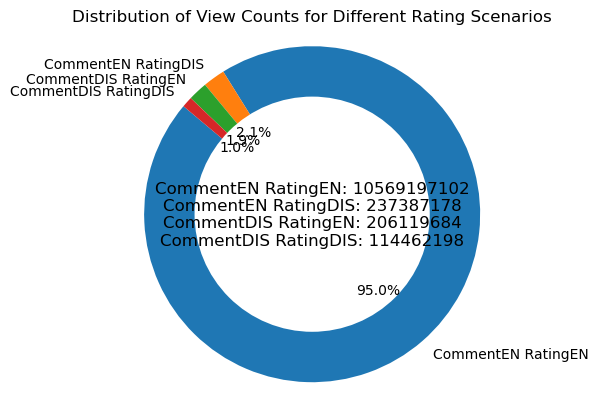

In [87]:
values = [commentEN_ratingEN, commentEN_ratingDIS, commentDIS_ratingEN, commentDIS_ratingDIS]
labels = ['CommentEN RatingEN', 'CommentEN RatingDIS', 'CommentDIS RatingEN', 'CommentDIS RatingDIS']

# Create a pie chart
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)

# Draw a circle at the center to make it look like a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that the pie chart is circular
plt.axis('equal')  

# Adding a title
plt.title('Distribution of View Counts for Different Rating Scenarios')

# Display the actual values in the center
plt.text(0, 0, '\n'.join([f'{label}: {value}' for label, value in zip(labels, values)]), 
         horizontalalignment='center', verticalalignment='center', fontsize=12, color='black')

# Display the chart
plt.show()

In [88]:
commentEN_ratingEN = commentEN_ratingEN_df['likes'].sum()

commentEN_ratingDIS = commentEN_ratingDIS_df['likes'].sum()

commentDIS_ratingEN = commentDIS_ratingEN_df['likes'].sum()

commentDIS_ratingDIS = commentDIS_ratingDIS_df['likes'].sum()

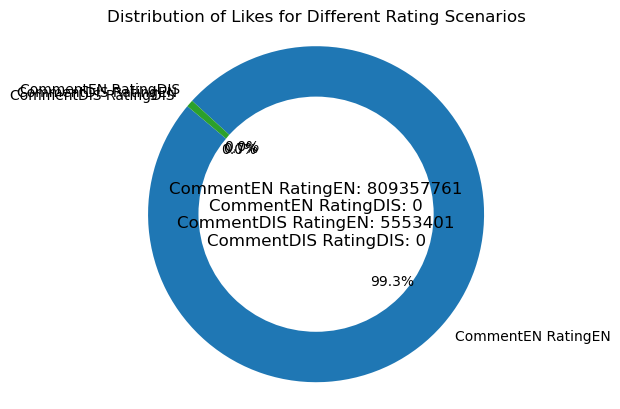

In [89]:
values = [commentEN_ratingEN, commentEN_ratingDIS, commentDIS_ratingEN, commentDIS_ratingDIS]
labels = ['CommentEN RatingEN', 'CommentEN RatingDIS', 'CommentDIS RatingEN', 'CommentDIS RatingDIS']

# Create a pie chart
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)

# Draw a circle at the center to make it look like a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that the pie chart is circular
plt.axis('equal')  

# Adding a title
plt.title('Distribution of Likes for Different Rating Scenarios')

# Display the actual values in the center
plt.text(0, 0, '\n'.join([f'{label}: {value}' for label, value in zip(labels, values)]), 
         horizontalalignment='center', verticalalignment='center', fontsize=12, color='black')

# Display the chart
plt.show()

In [90]:
commentEN_ratingEN = commentEN_ratingEN_df['dislikes'].sum()

commentEN_ratingDIS = commentEN_ratingDIS_df['dislikes'].sum()

commentDIS_ratingEN = commentDIS_ratingEN_df['dislikes'].sum()

commentDIS_ratingDIS = commentDIS_ratingDIS_df['dislikes'].sum()

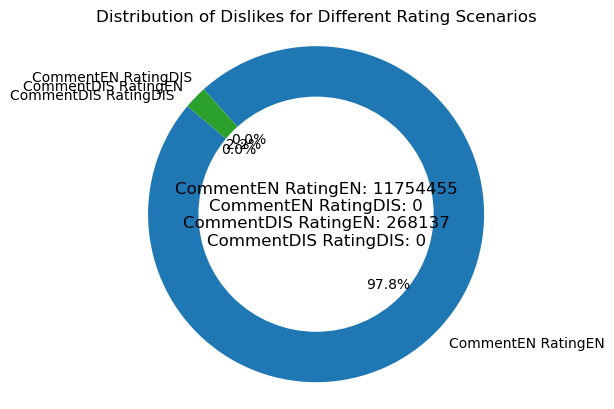

In [91]:
values = [commentEN_ratingEN, commentEN_ratingDIS, commentDIS_ratingEN, commentDIS_ratingDIS]
labels = ['CommentEN RatingEN', 'CommentEN RatingDIS', 'CommentDIS RatingEN', 'CommentDIS RatingDIS']

# Create a pie chart
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)

# Draw a circle at the center to make it look like a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that the pie chart is circular
plt.axis('equal')  

# Adding a title
plt.title('Distribution of Dislikes for Different Rating Scenarios')

# Display the actual values in the center
plt.text(0, 0, '\n'.join([f'{label}: {value}' for label, value in zip(labels, values)]), 
         horizontalalignment='center', verticalalignment='center', fontsize=12, color='black')

# Display the chart
plt.show()

In [92]:
disabled_count = df[df['comments_disabled'] == True].count()
enabled_count = df[df['comments_disabled'] == False].count()


print(f"Disabled Count: {disabled_count['title']}")
print(f"Enabled Count: {enabled_count['title']}")

Disabled Count: 317
Enabled Count: 17820


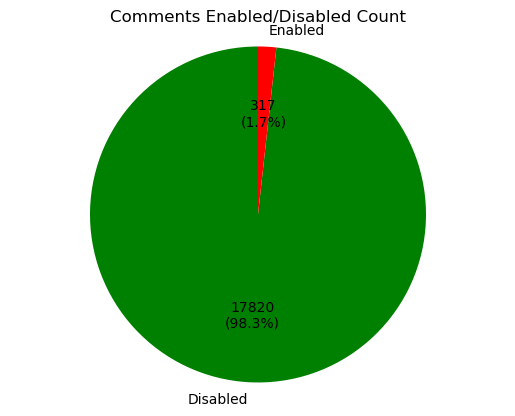

In [93]:
# Assuming disabled_count and enabled_count are DataFrame counts
disabled_count = df[df['comments_disabled'] == True].count()['title']
enabled_count = df[df['comments_disabled'] == False].count()['title']

# Data
labels = ['Disabled', 'Enabled']
values = [enabled_count, disabled_count]

# Plotting the pie chart with actual values
plt.pie(values, labels=labels, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(values) / 100, p), startangle=90, colors=['green', 'red'])

# Equal aspect ratio ensures that the pie chart is circular
plt.axis('equal')

# Adding a title
plt.title('Comments Enabled/Disabled Count')

# Display the pie chart
plt.show()